In [1]:
import base64
#import cStringIO
import sys
import tempfile
import time
MODEL_BASE = '/Users/aadebuger/GEXT/github2019/models/research'
MODEL_BASE = '/home/aadebugergf/Ai/github2019/models/research'


sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')


import numpy as np
from PIL import Image
from PIL import ImageDraw
import tensorflow as tf
from utils import label_map_util




PATH_TO_CKPT = '/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

content_types = {'jpg': 'image/jpeg',
                 'jpeg': 'image/jpeg',
                 'png': 'image/png'}
extensions = sorted(content_types.keys())


def is_image():
  def _is_image(form, field):
    if not field.data:
      raise ValidationError()
    elif field.data.filename.split('.')[-1].lower() not in extensions:
      raise ValidationError()

  return _is_image





class ObjectDetector(object):

  def __init__(self):
    self.detection_graph = self._build_graph()
    self.sess = tf.Session(graph=self.detection_graph)

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)

  def _build_graph(self):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    return detection_graph

  def _load_image_into_numpy_array(self, image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

  def detect(self, image):
    image_np = self._load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = self.detection_graph
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    boxes = graph.get_tensor_by_name('detection_boxes:0')
    scores = graph.get_tensor_by_name('detection_scores:0')
    classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')

    (boxes, scores, classes, num_detections) = self.sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    boxes, scores, classes, num_detections = map(
        np.squeeze, [boxes, scores, classes, num_detections])

    return boxes, scores, classes.astype(int), num_detections


def draw_bounding_box_on_image(image, box, color='red', thickness=4):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  print("rect,width="+str(right-left)+"height="+str(bottom-top))
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  print('(left, right, top, bottom)',(left, right, top, bottom))

from io import BytesIO
def encode_image(image):
  image_buffer = BytesIO()
  image.save(image_buffer, format='PNG')
  imagevalue = image_buffer.getvalue()
  base64str=base64.b64encode(imagevalue).decode()

  imgstr = 'data:image/png;base64,{:s}'.format(
     base64str )
  return imgstr


def detect_objects(image_path):
  start = time.time()
  
  image = Image.open(image_path).convert('RGB')
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
  print(num_detections)
  new_images = {}
  for i in range(int(num_detections)):

    if scores[i] < 0.35: continue
    print("scres[i",scores[i])
        
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)

  result = {}
#  result['original'] = encode_image(image.copy())
  print(new_images)
  count = 0 
  for cls, new_image in new_images.items():
    category = client.category_index[cls]['name']
    print(category)
    result[category] = encode_image(new_image)
    new_image.save("{0}.jpg".format(count))
    count=count+1
  end = time.time()
  print("execute2 time",(end-start)) 
  return result



PATH_TO_CKPT='/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'

PATH_TO_CKPT='/home/aadebugergf/Ai/models/fastrcnnstbmodelrtx220190703/frozen_inference_graph.pb'

client = ObjectDetector()

execute1 time 1.2214329242706299
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457576  0.61229384 0.79306746]
rect,width=118.7087345123291height=106.4240562915802
(left, right, top, bottom) (261.96364402770996, 380.67237854003906, 114.00172591209412, 220.42578220367432)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F230E36BE80>}
bicycle
execute2 time 1.2901973724365234
1



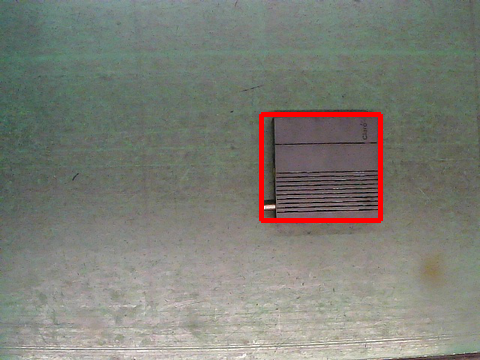

In [4]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.30121803283691406
200.0
scres[i 0.99999964
boxes [0.7061181 0.4360037 0.9659143 0.6260156]
rect,width=91.20570659637451height=93.52663278579712
(left, right, top, bottom) (209.28178310394287, 300.4874897003174, 254.20251846313477, 347.7291512489319)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F230E36BA20>}
bicycle
execute2 time 0.413196325302124
1



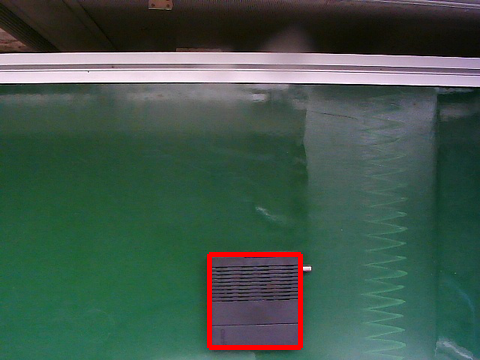

In [6]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628161926.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.30637574195861816
200.0
scres[i 0.99999905
boxes [0.71250564 0.2861519  0.971362   0.47427353]
rect,width=90.29839038848877height=93.18828821182251
(left, right, top, bottom) (137.3529052734375, 227.65129566192627, 256.50202989578247, 349.690318107605)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F2307C2CA90>}
bicycle
execute2 time 0.4159224033355713
1



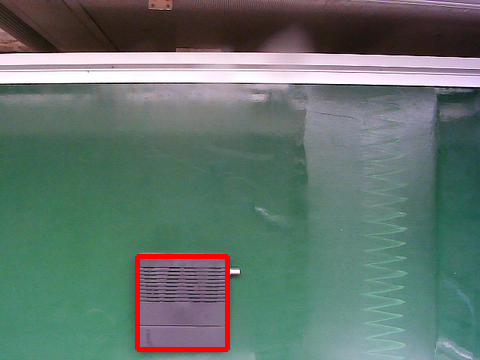

In [7]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628141813.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.28475069999694824
200.0
scres[i 0.9999995
boxes [0.68083763 0.4132646  0.9407993  0.6053454 ]
rect,width=92.19879627227783height=93.58619928359985
(left, right, top, bottom) (198.36700916290283, 290.56580543518066, 245.10154724121094, 338.6877465248108)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F230E36B710>}
bicycle
execute2 time 0.36899590492248535
1



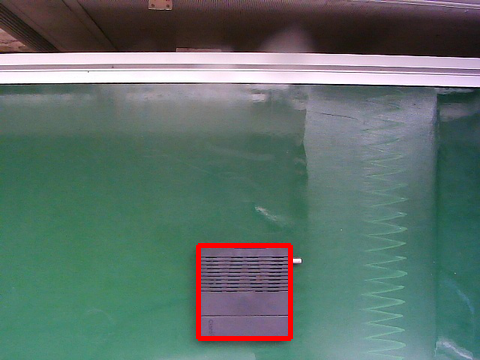

In [8]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628134640.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.27289485931396484
200.0
scres[i 0.99999905
boxes [0.71250564 0.2861519  0.971362   0.47427353]
rect,width=90.29839038848877height=93.18828821182251
(left, right, top, bottom) (137.3529052734375, 227.65129566192627, 256.50202989578247, 349.690318107605)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F2307C02C88>}
bicycle
execute2 time 0.3530142307281494
1



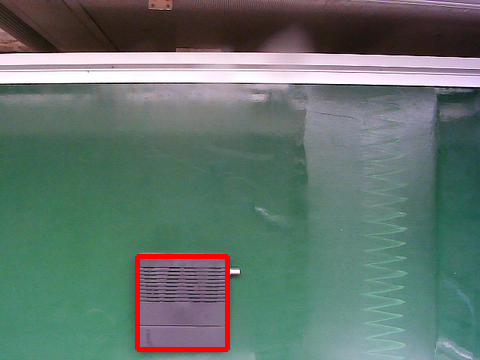

In [9]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190628141813.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.302976131439209
200.0
scres[i 0.9999993
boxes [0.67594934 0.32854095 0.93868613 0.5212468 ]
rect,width=92.49880313873291height=94.58524703979492
(left, right, top, bottom) (157.69965648651123, 250.19845962524414, 243.34176063537598, 337.9270076751709)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F2307C02FD0>}
bicycle
execute2 time 0.4133472442626953
1



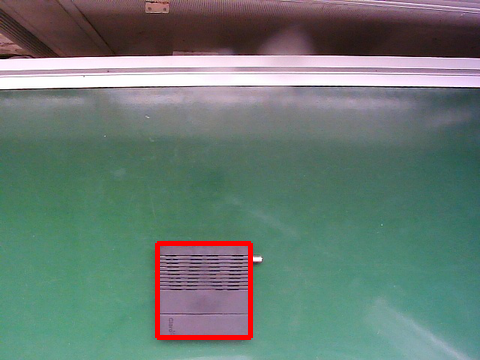

In [10]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190626114548.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 4.741215467453003
200.0
scres[i 0.923528
boxes [0.54207367 0.36548132 0.8715383  0.6041486 ]
rect,width=114.5603084564209height=118.60726118087769
(left, right, top, bottom) (175.43103218078613, 289.99134063720703, 195.14652013778687, 313.75378131866455)
scres[i 0.8342801
boxes [0.5438473  0.3586795  0.86761576 0.5998085 ]
rect,width=115.74192523956299height=116.55663728713989
(left, right, top, bottom) (172.1661615371704, 287.9080867767334, 195.78503608703613, 312.341673374176)
{1: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F5607CE6320>, 2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F55644ED128>}
person
bicycle
execute2 time 4.915637493133545
2



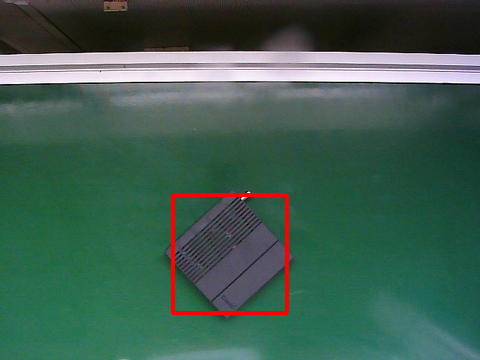

In [2]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/object20190705141654.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 1.6730155944824219
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457575  0.6122939  0.79306746]
rect,width=118.70879173278809height=106.42407774925232
(left, right, top, bottom) (261.963586807251, 380.67237854003906, 114.00172591209412, 220.42580366134644)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F17888B2C50>}
bicycle
execute2 time 1.7591545581817627
1



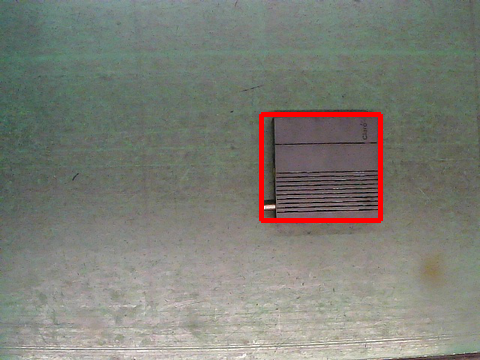

In [2]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 6.855746030807495
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457576  0.61229384 0.79306746]
rect,width=118.7087345123291height=106.4240562915802
(left, right, top, bottom) (261.96364402770996, 380.67237854003906, 114.00172591209412, 220.42578220367432)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F19F024A320>}
bicycle
execute2 time 6.922009229660034
1



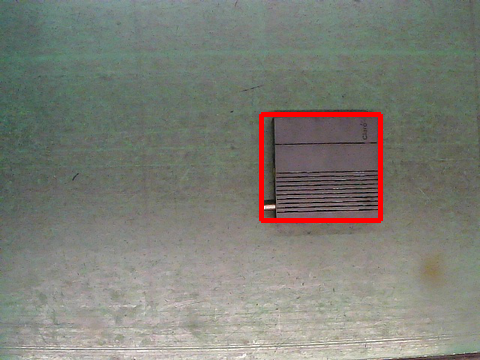

In [2]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.2610306739807129
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457576  0.61229384 0.79306746]
rect,width=118.7087345123291height=106.4240562915802
(left, right, top, bottom) (261.96364402770996, 380.67237854003906, 114.00172591209412, 220.42578220367432)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F19345FD470>}
bicycle
execute2 time 0.32751917839050293
1



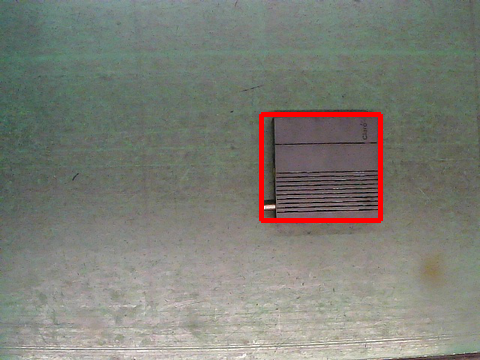

In [3]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 4.274333477020264
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457576  0.61229384 0.79306746]
rect,width=118.7087345123291height=106.4240562915802
(left, right, top, bottom) (261.96364402770996, 380.67237854003906, 114.00172591209412, 220.42578220367432)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F59B43B5978>}
bicycle
execute2 time 4.340895891189575
1



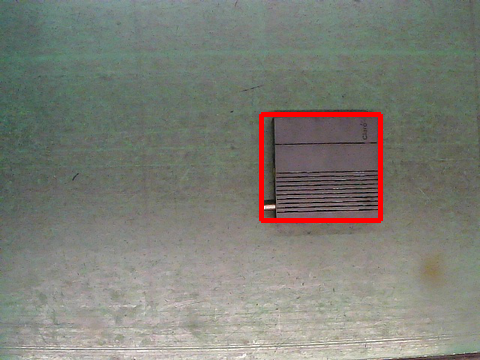

In [2]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.2606470584869385
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457576  0.61229384 0.79306746]
rect,width=118.7087345123291height=106.4240562915802
(left, right, top, bottom) (261.96364402770996, 380.67237854003906, 114.00172591209412, 220.42578220367432)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F59149C5DD8>}
bicycle
execute2 time 0.3547329902648926
1



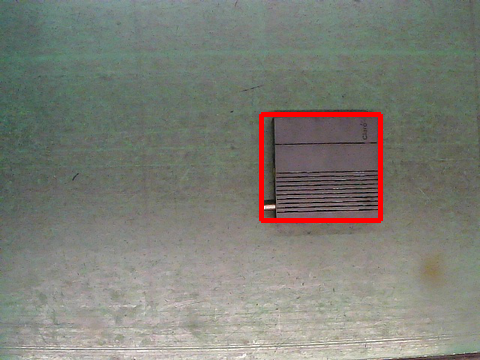

In [3]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 4.3200905323028564
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457576  0.61229384 0.79306746]
rect,width=118.7087345123291height=106.4240562915802
(left, right, top, bottom) (261.96364402770996, 380.67237854003906, 114.00172591209412, 220.42578220367432)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F349C09FBE0>}
bicycle
execute2 time 4.3875555992126465
1



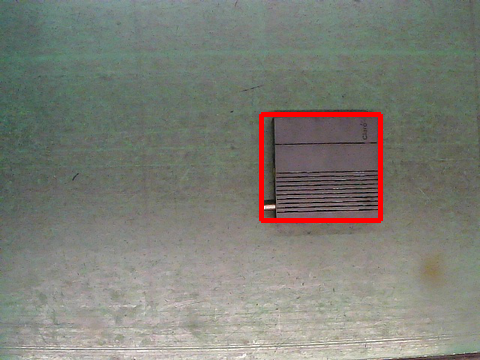

In [2]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.2651181221008301
200.0
scres[i 0.99999964
boxes [0.31667146 0.5457576  0.61229384 0.79306746]
rect,width=118.7087345123291height=106.4240562915802
(left, right, top, bottom) (261.96364402770996, 380.67237854003906, 114.00172591209412, 220.42578220367432)
{2: <PIL.Image.Image image mode=RGB size=480x360 at 0x7F33F44A5400>}
bicycle
execute2 time 0.36572861671447754
1



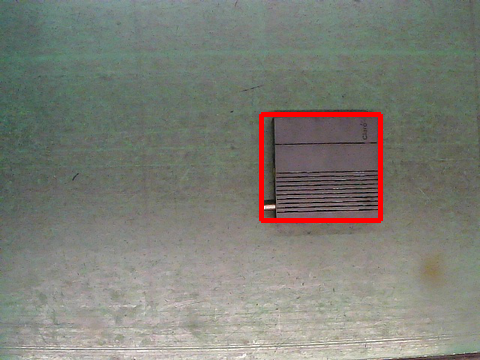

In [3]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426121940.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))